In [1]:
import sys
import os
import matplotlib.pyplot as plt
% matplotlib notebook
import pickle
# Import class
parent_dir = os.path.dirname(os.getcwd())
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import random
import seaborn as sns

In [2]:
parent_dir = os.path.dirname(os.getcwd())
stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\johnn\Desktop\github\nba_stats\Data\nba_stats.pickle


In [3]:
def get_player_df(nba_stats, player, player_id=False):
    ''' Get the dataframe containing info on referenced player. If player_id=True, player id given instead of name'''
    if player_id:
        if player not in nba_stats.get_player_stats().keys():
            raise ValueError('player_id {} not found'.format(player))
        
        return nba_stats.get_player_stats()[player].sort_index(ascending=False)
    else:
        if player not in nba_stats.get_player_name_id_dict().keys():
            raise ValueError('player name {} not found'.format(player))
        
        return nba_stats.get_player_stats()[nba_stats.get_player_name_id_dict()[player]].sort_index(ascending=False)

# Clean data
Write a few functions to clean the data into a format we like:
* Add distinction between 3pt and 2pt FG
* Converts relevant columns to numeric data

In [4]:
def get_FG2(player_df):
    ''' Adds FG2M, FG2A, and FG2_PCT '''
    player_df['FG2M'] = player_df['FGM'] - player_df['FG3M']
    player_df['FG2A'] = player_df['FGA'] - player_df['FG3A']
    player_df['FG2_PCT'] = player_df['FG2M'].div(player_df['FG2A'].apply(lambda x: 0 if x is None else max(1, x)))
    
    return player_df

In [5]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

In [6]:
def jitter(x, std=0.1):
    ''' Takes in a series and adds some noise. Makes plotting easier'''
    return x + np.random.randn(len(x)) * std

# Analysis
Do preliminary analysis on one single player with lots of data. Picked Stephen Curry arbitrarily.

In [7]:
df_player = get_player_df(nba_stats, 'Stephen Curry')
df_player = player_df_convert_numeric(df_player)
df_player = get_FG2(df_player)

## FGA
Hypothesise that FGA is Poisson. Scatter plot seems to support this. Mean looks linear, and variance increases with MIN.

<IPython.core.display.Javascript object>


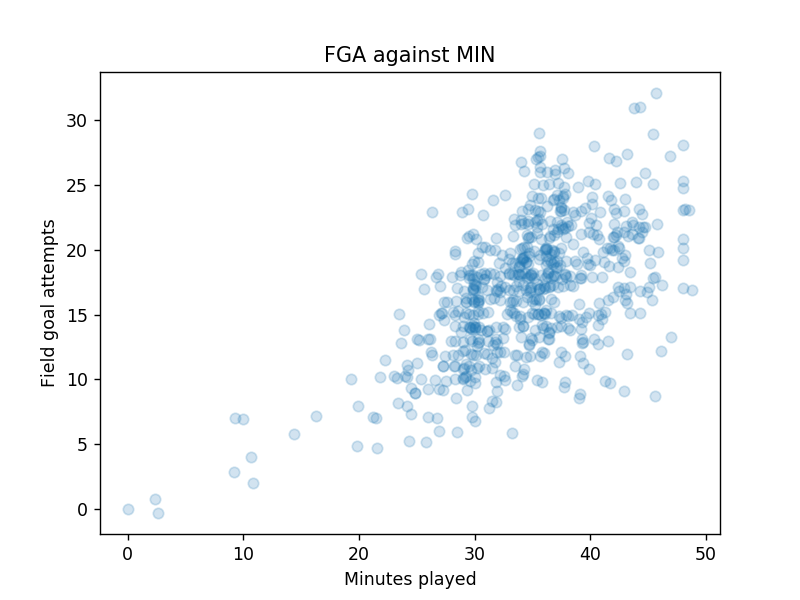

Text(0,0.5,'Field goal attempts')

In [16]:
df_player_played = df_player[df_player.MIN > 0]
plt.scatter(x=df_player_played.MIN, y=jitter(df_player_played.FGA, std=0.2), alpha=0.2)
plt.title('FGA against MIN')
plt.xlabel('Minutes played')
plt.ylabel('Field goal attempts')

In [18]:
# sns.lmplot(x='MIN', y= 'FGA', data=df_player_played)

### Linear regression
Run a linear regression to get an estimate for $\lambda$

#### Linear regression with sklearn

In [44]:
import sklearn.linear_model

X = np.array(df_player_played.MIN).reshape(-1, 1)
y = np.array(df_player_played.FGA)

lin_regr_FGA = sklearn.linear_model.LinearRegression(fit_intercept=False) # Set intercept to 0
lin_regr_FGA.fit(X, Y)

# Estimated parameters
print('Intercept {}'.format(lin_regr_FGA.intercept_))
print('Slope {}'.format(lin_regr_FGA.coef_))

Intercept 0.0
Slope [ 0.48948064]


#### Linear regression with statsmodel

In [49]:
import statsmodels.api as sm

lin_regr_FGA_sm = sm.OLS(y, X, hasconst=0).fit()
lin_regr_FGA_sm.params

array([0.4894806359372042], dtype=object)